# Optimization of $Y(A,TKE)$ for Cf-252 with Hierarchical parameterization

In [20]:
import numpy as np
import scipy as sp
import scipy.optimize as opt
import os
from statistics import *
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import sympy as sym
from sympy.interactive import printing
printing.init_printing(use_latex = 'mathjax')
from IPython.display import display, Math, Latex
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.ticker as ticker
from matplotlib.pyplot import cm
import pylab as pl
from scipy.stats import chisquare
%matplotlib inline

In [2]:
### rcParams are the default parameters for matplotlib
import matplotlib as mpl

print ("Matplotbib Version: ", mpl.__version__)

mpl.rcParams['font.size'] = 18
mpl.rcParams['font.family'] = 'Helvetica', 'serif'
#mpl.rcParams['font.color'] = 'darkred'
mpl.rcParams['font.weight'] = 'normal'

mpl.rcParams['axes.labelsize'] = 18.
mpl.rcParams['xtick.labelsize'] = 18.
mpl.rcParams['ytick.labelsize'] = 18.
mpl.rcParams['lines.linewidth'] = 2.

font = {'family' : 'serif',
        'color'  : 'darkred',
        'weight' : 'normal',
        'size'   : 18,
        }

mpl.rcParams['xtick.major.pad']='10'
mpl.rcParams['ytick.major.pad']='10'

mpl.rcParams['image.cmap'] = 'inferno'

Matplotbib Version:  2.0.2


In [3]:
def rearrange(YATKE):
    return np.transpose(np.asarray(YATKE).reshape(150, 200))

def YATKEplot(YATKE):
    fig, axes = pl.subplots(1, 1, figsize=(15, 10))
    c1 = plt.imshow(YATKE, extent=[51,200, 100,299], origin="lower")
    plt.xlabel('A')
    plt.ylabel('TKE')
    plt.colorbar(fraction=0.03, pad=0.04)
    plt.xlim(80,170)
    plt.ylim(150,225)
    
def gauss(x,mu,sigma,w):
    return w/sigma/np.sqrt(2*np.pi)*np.exp(-(x-mu)**2/2/sigma**2)

def bimodal(x,mu1,sigma1,w1,mu2,sigma2,w2):
    return gauss(x,mu1,sigma1,w1)+gauss(x,mu2,sigma2,w2)

In [30]:
#get yield data for Cf 252 *************************************************************************************
f=open(os.path.join(os.getcwd(),'yieldsATKE.Cf252.sf.dat3'),"r")
lines=f.readlines()
YATKE_data=[]
for x in lines:
    x = x.split()
    if len(x) != 0:
        YATKE_data.append(x[2])
f.close()

#convert from strings to ints
YATKE_data = np.asarray(list(map(float, YATKE_data)))

In [8]:
# model according to Brosa

def YATKE(tuple_in, h0,h1,h2, dmin0,dmin1,dmin2, dmax0,dmax1,dmax2,
         ddec0,ddec1,ddec2, Abar0,Abar1,Abar2, sigA0,sigA1,sigA2):
    
    #unpack the tuple
    A, TKE = tuple_in
    
    # pack the arrays - order of the modes is: SL, S1, S2
    # 30 total parameters, 5 modes x 6 parameters
    h           = np.array([h0,h1,h2])
    dmin        = np.array([dmin0, dmin1, dmin2])
    dmax        = np.array([dmax0, dmax1, dmax2]) 
    ddec        = np.array([ddec0, ddec1, ddec2])
    Abar        = np.array([Abar0, Abar1, Abar2])
    sigA        = np.array([sigA0, sigA1, sigA2])
    
    
    # define YATKE
    Y = [] # yield list that will be returned
    
    # sub "cn" refers to 'compound nucleus' - in this case the 252 pre-fission nucleus
    A_cn = 252.
    Z_cn = 98.
    
    e2 = 1.4399643929 # MeV fm
    #see http://www.vanderbilt.edu/AnS/physics/volker/p340a/section_1/1.3_notes_nucl_units.pdf
                        # e^2 = alpha * hbar * c
    # i index over A - turn into columns when rearranged
    for i in range(len(A)):
        # j index over TKE - rows of rearranged data
        for j in range(len(TKE)):
            Yij = 0.

            # k index over modes
            for k in range(len(h)):
                
                T = (Z_cn / A_cn) ** 2 * (A[i] * (A_cn - A[i]) * e2) / TKE[j] - dmin[k] # fm
                
                if (T <= 0.0):
                    Yij += 0.
                else:
                    YTKE = (200/TKE[j])** 2 * h[k] * np.exp(2*(dmax[k]-dmin[k])/ddec[k] - 
                                                       T/ddec[k] - (dmax[k] - dmin[k])**2/T/ddec[k])
                
                    #remember that the sL mode is NOT bimodal
                    if (k != 0):
                    
                        YA = 1/np.sqrt(8*np.pi*sigA[k]**2) * \
                        (np.exp(-(A[i]-Abar[k])**2/(2*sigA[k]**2)) + \
                         np.exp(-(A[i]-A_cn+Abar[k])**2/(2*sigA[k]**2)))
                        
                    else:
                        YA = 1/np.sqrt(2*np.pi*sigA[k]**2) * \
                        np.exp(-(A[i]-Abar[k])**2/(2*sigA[k]**2))

                    Yij += YTKE * YA
                
            Y.append(Yij)
    
    return np.asarray(Y)

In [10]:
# initial fit to get parameters for initial guesses

hl, h1, h2 = 2.02e4, 1.47e5, 8.7e5
dminl, dmin1, dmin2 = 16.8, 10.9, 13.7
dmaxl, dmax1, dmax2 = 18.7, 17.1, 17.9
ddecl, ddec1, ddec2 = 0.521, 0.125, 0.270
Abarl, Abar1, Abar2 = 126.9, 134.9, 142.5
sigAl, sigA1, sigA2 = 11.62, 3.16,  4.99

# define A
A = np.linspace(51,200,150)

# define TKE
TKE = np.linspace(100,299,200)

YATKE_prior = YATKE((A,TKE), hl, h1, h2, dminl, dmin1, dmin2, dmaxl, dmax1, dmax2, 
                   ddecl, ddec1, ddec2, Abarl, Abar1, Abar2, sigAl, sigA1, sigA2)

In [11]:
guess0 = (hl, h1, h2, dminl, dmin1, dmin2, dmaxl, dmax1, dmax2, ddecl, ddec1, ddec2, 
          Abarl, Abar1, Abar2, sigAl, sigA1, sigA2)
popt,pcov = opt.curve_fit(YATKE, (A, TKE), YATKE_data, p0=guess0)


/home/austinlc/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:44: RuntimeWarning: overflow encountered in exp


In [14]:
YATKE_fit1 = YATKE((A,TKE), *popt)
print(popt)

[  8.64060843e+04   3.64190445e+05   6.38441071e+05   1.75506847e+01
   9.64490701e+00   1.51667603e+01   1.92481672e+01   1.76145329e+01
   1.83696065e+01   5.99957649e-01   1.13213029e-01   4.06062975e-01
   1.28930770e+02   1.38976552e+02   1.44708876e+02   2.81084961e+01
   5.47114181e+00   5.74680173e+00]


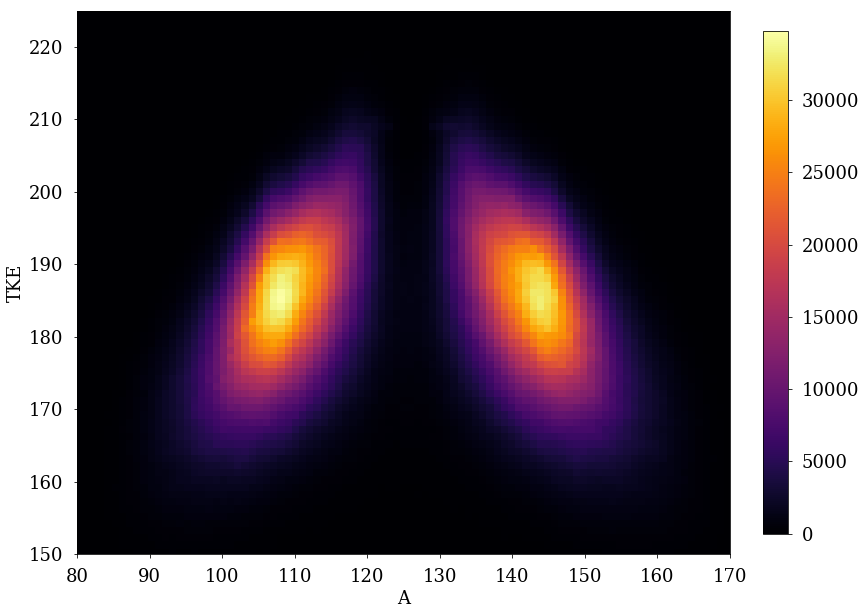

In [15]:
YATKEplot(rearrange(YATKE_data))

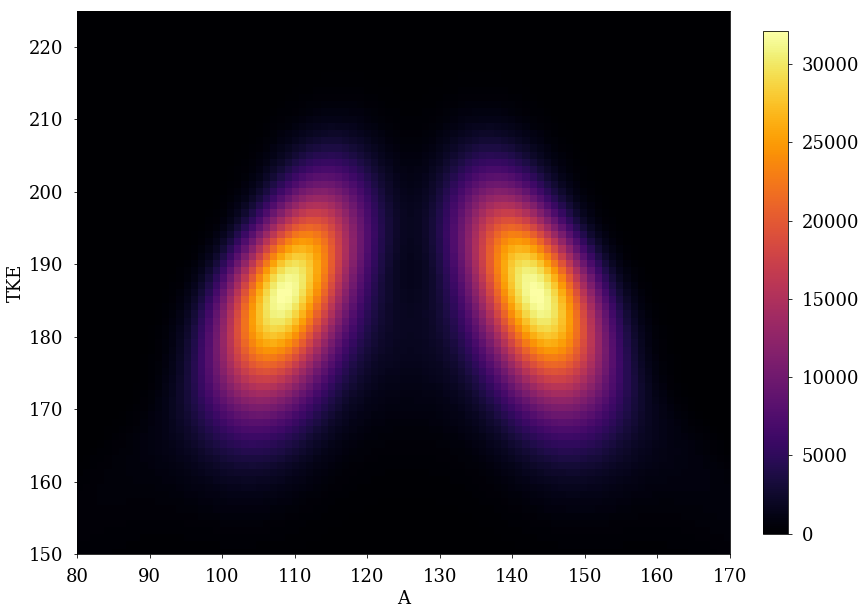

In [16]:
YATKEplot(rearrange(YATKE_fit1))

[ 1.  1.  1. ...,  1.  1.  1.]
Power_divergenceResult(statistic=12950978.559780182, pvalue=0.0)


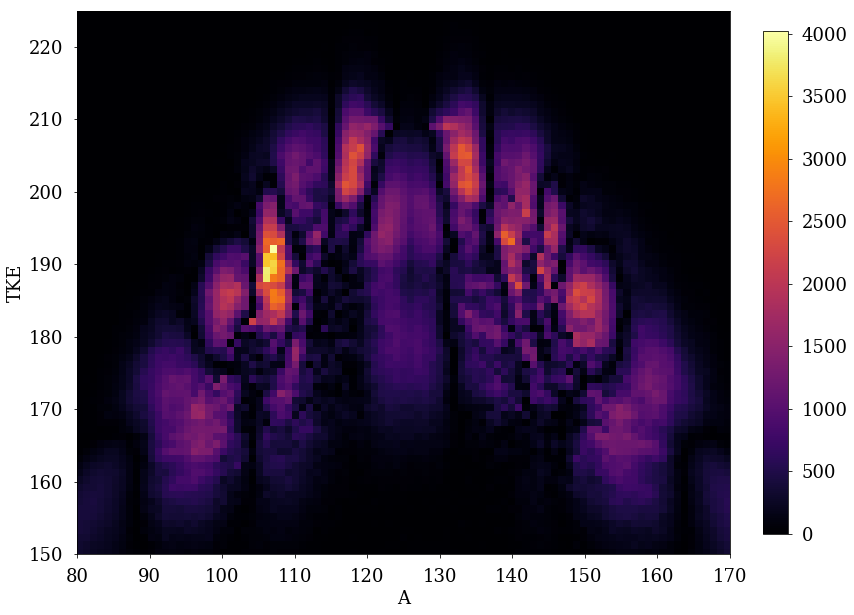

In [33]:
YATKEplot(np.abs(rearrange(YATKE_fit1) - rearrange(YATKE_data)))
print(YATKE_data[YATKE_data != 0.])
chi2fit1 = chisquare(YATKE_fit1[YATKE_data != 0.], YATKE_data[YATKE_data != 0.])
print(chi2fit1)

In [44]:
# create functions for projection onto 1d for Y(A) and Y(TKE)

def YAproj(YATKE, A = np.linspace(51,200,150)):
    
    YA = np.zeros(len(A))
    for i in range(len(A)):
        YA[i]    = sum(YATKE[:,i])
        
    # normalize to pdf 
    total = sum(YA)
    YA = np.asarray([float(i)/total for i in YA])
    return YA

def YTKEproj(YATKE, A = np.linspace(100,299,200)):
    
    YTKE = np.zeros(len(TKE))
    for i in range(len(TKE)):
        YTKE[i]    = sum(YATKE[i,:])
        
    return YTKE

20200.0 147000.0 870000.0 16.8 10.9 13.7 18.7 17.1 17.9 0.521 0.125 0.27 126.9 134.9 142.5 11.62 3.16 4.99
[  8.64060843e+04   3.64190445e+05   6.38441071e+05   1.75506847e+01
   9.64490701e+00   1.51667603e+01   1.92481672e+01   1.76145329e+01
   1.83696065e+01   5.99957649e-01   1.13213029e-01   4.06062975e-01
   1.28930770e+02   1.38976552e+02   1.44708876e+02   2.81084961e+01
   5.47114181e+00   5.74680173e+00]
0.019475510991129964
0.0793416905159
0.14172772849980717
0.334414940902
0.8387967605090628
0.586243368582


(1e-07, 10000000.0)

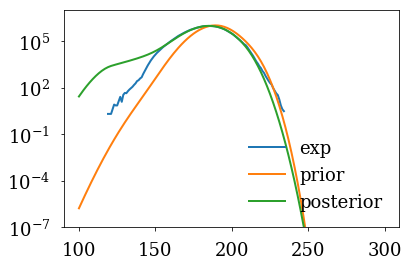

In [128]:
print(hl, h1, h2, dminl, dmin1, dmin2, dmaxl, dmax1, dmax2, 
                   ddecl, ddec1, ddec2, Abarl, Abar1, Abar2, sigAl, sigA1, sigA2)


print(popt)

print(hl/(hl+h1+h2))
print(popt[0]/ sum(popt[:3]))

print(h1/(hl+h1+h2))
print(popt[1]/ sum(popt[:3]))

print(h2/(hl+h1+h2))
print(popt[2]/ sum(popt[:3]))

plt.semilogy(TKE,YTKEproj(rearrange(YATKE_data)), label = 'exp')
plt.semilogy(TKE,YTKEproj(rearrange(YATKE_prior)), label = 'prior')
plt.semilogy(TKE,YTKEproj(rearrange(YATKE((A,TKE), *popt))), label = 'posterior')
lg = plt.legend(numpoints=1,fontsize=18, loc='best')
lg.draw_frame(False)
plt.ylim(1e-7, 1e7)

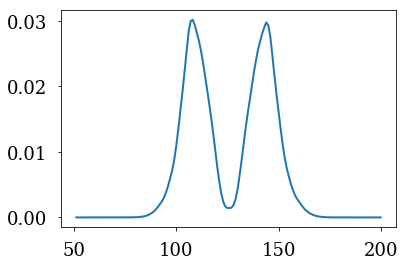

In [45]:
plt.plot(A,YAproj(rearrange(YATKE_data)))

[  8.64060843e+04   3.64190445e+05   6.38441071e+05   1.26000000e+02
   1.38976552e+02   1.44708876e+02   2.81084961e+01   5.47114181e+00
   5.74680173e+00]


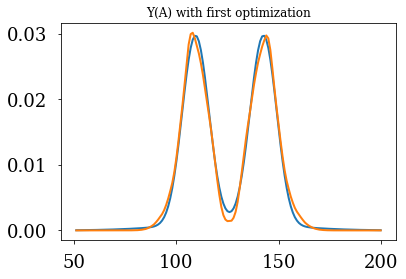

In [70]:
# plan: make a fit to Y(A) and get best fits for Abar and sig A for s1, s2, and sL individually
# hierarchy is:
    # Abar s2
    # Abar s1
    # sigA s2
    # sigA s1
    # Abar sl
    # sigA sl
    
    
def YA(A, hl, h1, h2, Abarsl, Abars1, Abars2, sigAsl, sigAs1, sigAs2):
    A_cn = 252.
    YA = np.zeros(len(A))
    for i in range(len(A)):
        YA[i] += bimodal(A[i],Abars2,sigAs2,h2/2.,(A_cn - Abars2),sigAs2,h2/2.)
        YA[i] += bimodal(A[i],Abars1,sigAs1,h1/2.,(A_cn - Abars1),sigAs1,h1/2.)
        YA[i] += gauss(A[i],Abarsl,sigAsl,hl)
        
    # normalize to pdf 
    total = sum(YA)
    YA = np.asarray([float(i)/total for i in YA])
    
    return YA

opt_in = np.concatenate([popt[:3], popt[12:]])
#set Abarsl = 126
opt_in[3] = 126.
plt.plot(A,YA(A, *opt_in))
plt.plot(A,YAproj(rearrange(YATKE_data)))
plt.title('Y(A) with first optimization')
print(opt_in)


[  1.64521896e+06   1.44015351e+02   6.43366775e+00]
[  8.64060843e+04   3.64190445e+05   1.64521896e+06   1.26000000e+02
   1.38976552e+02   1.44015351e+02   2.81084961e+01   5.47114181e+00
   6.43366775e+00]
Power_divergenceResult(statistic=0.41101113051722216, pvalue=1.0)


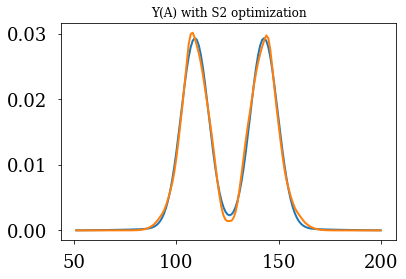

In [71]:
YA_data = YAproj(rearrange(YATKE_data))

popts2,pcovs2 = opt.curve_fit(lambda A, h2, Abars2, sigAs2: 
                              YA(A, opt_in[0], opt_in[1], h2, 
                                 opt_in[3], opt_in[4], Abars2, 
                                 opt_in[6], opt_in[7], sigAs2),
                              A, YA_data, p0=[opt_in[2], opt_in[5], opt_in[8]])
print(popts2)
popts2 = np.hstack([opt_in[:2], np.array(popts2[0]), opt_in[3:5], np.array(popts2[1]), opt_in[6:8], np.array(popts2[2])])
print(popts2)
chi2fits2 = chisquare(YA(A, *popts2)[YA_data != 0.], YA_data[YA_data != 0.])
print(chi2fits2)
plt.plot(A,YA(A, *popts2))
plt.plot(A,YA_data)
plt.title('Y(A) with S2 optimization')

[  3.63417407e+05   1.38902683e+02   5.53536862e+00]
[  8.64060843e+04   3.63417407e+05   1.64521896e+06   1.26000000e+02
   1.38902683e+02   1.44015351e+02   2.81084961e+01   5.53536862e+00
   6.43366775e+00]
Power_divergenceResult(statistic=0.41184398414561618, pvalue=1.0)


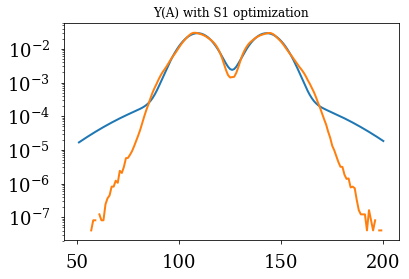

In [92]:
popts1,pcovs1 = opt.curve_fit(lambda A, h1, Abars1, sigAs1: 
                              YA(A, popts2[0], h1, popts2[2], 
                                 popts2[3], Abars1, popts2[5], 
                                 popts2[6], sigAs1, popts2[8]),
                              A, YA_data, p0=[popts2[1], popts2[4], popts2[7]])
print(popts1)
popts1 = np.array([popts2[0], popts1[0], popts2[2], 
                   popts2[3], popts1[1], popts2[5], 
                   popts2[6], popts1[2], popts2[8]])
print(popts1)
chi2fits1 = chisquare(YA(A, *popts1)[YA_data != 0.], YA_data[YA_data != 0.])
print(chi2fits1)
plt.semilogy(A,YA(A, *popts1))
plt.semilogy(A,YA_data)
plt.title('Y(A) with S1 optimization')

[  7.77665303e+04   3.47248030e+01]
[  7.77665303e+04   3.63417407e+05   1.64521896e+06   1.26000000e+02
   1.38902683e+02   1.44015351e+02   1.40000000e+01   5.53536862e+00
   6.43366775e+00]
Power_divergenceResult(statistic=0.021678657576102434, pvalue=1.0)


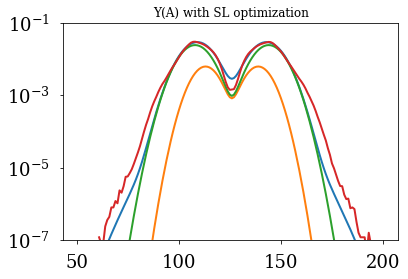

In [112]:
poptsl,pcovsl = opt.curve_fit(lambda A, hl, sigAsl: 
                              YA(A, hl, popts1[1], popts1[2], 
                                 popts1[3], popts1[4], popts1[5], 
                                sigAsl, popts1[7], popts1[8]),
                              A, YA_data, p0=[popts1[0], popts1[6]])
print(poptsl)
poptsl = np.array([poptsl[0], popts1[1], popts1[2], 
                   popts1[3], popts1[4], popts1[5], 
                   14., popts1[7], popts1[8]])
print(poptsl)
chi2fitsl = chisquare(YA(A, *poptsl)[YA_data != 0.], YA_data[YA_data != 0.])
print(chi2fitsl)
plt.semilogy(A,YA(A, *poptsl))
S2_contribution = np.zeros(len(A))
for i in range(len(A)):
    S2_contribution[i] = bimodal(A[i],popts1[5],popts1[8],popts1[2]/sum(popts1[0:3])/2.,(252. - popts1[5]),popts1[8],popts1[2]/sum(popts1[0:3])/2.)
    
S1_contribution = np.zeros(len(A))
for i in range(len(A)):
    S1_contribution[i] = bimodal(A[i],popts1[4],popts1[7],popts1[1]/sum(popts1[0:3])/2.,(252. - popts1[4]),popts1[7],popts1[1]/sum(popts1[0:3])/2.) 

plt.semilogy(A, S1_contribution) 
plt.semilogy(A, S2_contribution)
plt.semilogy(A,YA_data)
plt.ylim(1e-7,1e-1)
plt.title('Y(A) with SL optimization')